In [17]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import learning_curve
import seaborn as sns
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc

In [18]:
df = pd.read_pickle("../data/depresjon/depresjon_preprocessed.pkl")
df.head()

,user_id,activity,days,gender,age,afftype,melanch,inpatient,edu,marriage,...,month_sin,weekday_sin,week_sin,day_sin,month_cos,weekday_cos,week_cos,day_cos,activity_quantile,user_activity_quantile
0,1,174.144444,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.974928,-0.998027,0.988468,-0.222521,-0.222521,0.062791,0.151428,1,1
1,1,156.247222,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,0.433884,-0.998027,0.998717,-0.222521,-0.900969,0.062791,-0.050649,1,1
2,1,124.135417,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.433884,-0.998027,0.968077,-0.222521,-0.900969,0.062791,-0.250653,1,1
3,1,134.961806,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.974928,-0.998027,0.897805,-0.222521,-0.222521,0.062791,-0.440394,1,1
4,1,99.439583,11,2,1,2.0,2.0,2.0,1,1.0,...,-0.974928,-0.781831,-0.998027,0.790776,-0.222521,0.623490,0.062791,-0.612106,1,0


In [19]:
df.columns

Index(['user_id', 'activity', 'days', 'gender', 'age', 'afftype', 'melanch',
       'inpatient', 'edu', 'marriage', 'work', 'is_weekend', 'category_madrs',
       'month_sin', 'weekday_sin', 'week_sin', 'day_sin', 'month_cos',
       'weekday_cos', 'week_cos', 'day_cos', 'activity_quantile',
       'user_activity_quantile'],
      dtype='object')

In [20]:
X = df.drop(['user_id', 'category_madrs'], axis=1)
y = df['category_madrs']
groups = df['user_id']

logo = LeaveOneGroupOut()

rf = RandomForestClassifier(random_state=42)

accuracy_list = []
y_true, y_scores = [], []

for train_index, test_index in logo.split(X, y, groups):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]

    scaler = StandardScaler() # or MinMaxScaler()

    # Fit the scaler on the training data
    scaler.fit(X_train)

    # Scale both the training and test data
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Initialize and train the classifier
    rf = RandomForestClassifier(random_state=42)
    rf.fit(X_train_scaled, y_train)

    # Make predictions and evaluate the model
    y_pred = rf.predict(X_test_scaled)
    accuracy_list.append(accuracy_score(y_test, y_pred))

    # Get the score (probability) of the positive class
    y_score = rf.predict_proba(X_test_scaled)[:, 1]

    # Append to the lists
    y_true.extend(y_test)
    y_scores.extend(y_score)

# Average metrics
print(f"Average Accuracy: {np.mean(accuracy_list)}")

Average Accuracy: 0.3478052584670232


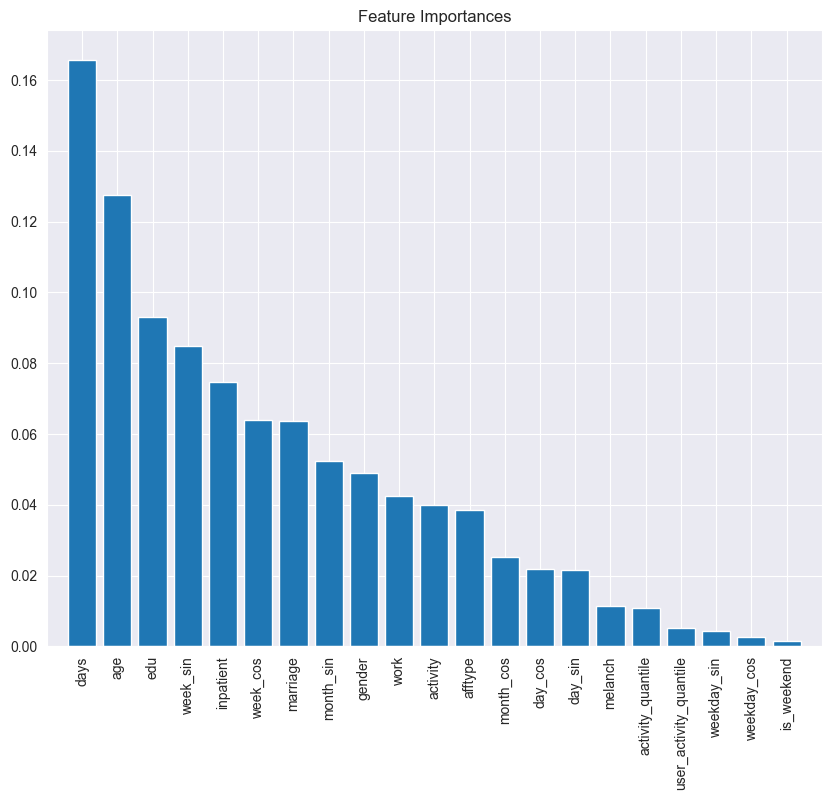

In [21]:
feature_importances = rf.feature_importances_
features = X.columns

# Sorting the feature importances in descending order
indices = np.argsort(feature_importances)[::-1]
plt.figure(figsize=(10, 8))
plt.title("Feature Importances")
plt.bar(range(X_train.shape[1]), feature_importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), [features[i] for i in indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [22]:
fpr, tpr, thresholds = roc_curve(y_true, y_scores)
roc_auc = auc(fpr, tpr)

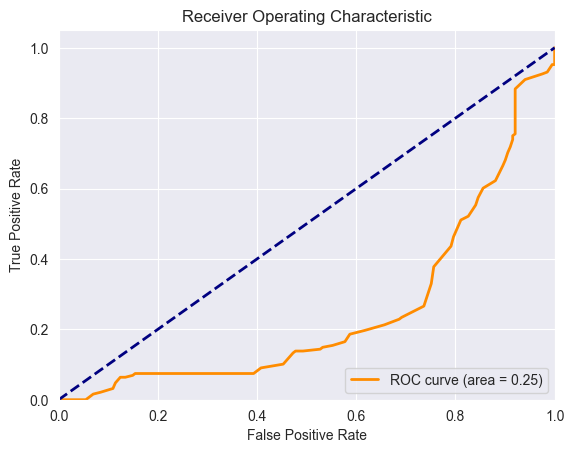

In [23]:
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()

In [ ]:
#create_report(df).show_browser()

In [ ]:
def train_test_split_by_user(df, target_column_name, test_size=0.2, random_state=None):
    """
    Splits a DataFrame into training and testing sets, ensuring that each user is only in one set.
    The user_id column is dropped from the resulting datasets.

    Parameters:
    - df: The DataFrame to split.
    - target_column_name: The name of the target variable column.
    - test_size: The proportion of users to include in the test set.
    - random_state: The seed used by the random number generator (for reproducibility).

    Returns:
    - X_train, X_test, y_train, y_test: The split datasets.
    """

    users = df['user_id'].unique()
    train_users, test_users = train_test_split(users, test_size=test_size, random_state=random_state)

    train_df = df[df['user_id'].isin(train_users)]
    test_df = df[df['user_id'].isin(test_users)]

    X_train = train_df.drop([target_column_name, 'user_id'], axis=1)
    X_test = test_df.drop([target_column_name, 'user_id'], axis=1)
    y_train = train_df[target_column_name]
    y_test = test_df[target_column_name]

    return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split_by_user(df, 'category_madrs', test_size=0.3, random_state=42)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

In [ ]:
clf = RandomForestClassifier(random_state=42)
clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=True, yticklabels=True)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate a plot showing the training and cross-validation score along with the number of training examples.
    """
    plt.figure(figsize=(10, 6))
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")

    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")

    return plt

# Customize these parameters as needed
title = "Learning Curves (Random Forest)"
cv = 10  # Cross-validation strategy
n_jobs = -1  # Use all available cores

plot_learning_curve(clf, title, X_train, y_train, ylim=(0.7, 1.01), cv=cv, n_jobs=n_jobs)
plt.show()